# **Previsão básica de ações utilizando Multi Layer Perceptron**

- Diogo Nunes Batista
- Rafael de Oliveira Évora
- Vinicius Gabriel 

### Carregamento dos dados

In [4]:
import pandas 
import numpy as np

STOCK_NAME = 'IRBR3'

df = pandas.read_csv(f'data/final/{STOCK_NAME}.csv', index_col='DATA', sep=';', decimal='.')
df

,ABERTURA,FECHAMENTO,VARIAÇÃO,MÍNIMO,MÁXIMO,VOLUME,SELIC
DATA,,,,,,,
25/04/2024,0.4080,0.4124,0.10118,0.4030,0.4140,0.04464,0.040168
26/04/2024,0.4153,0.4235,0.10269,0.4125,0.4276,0.05496,0.040168
29/04/2024,0.4215,0.4302,0.10158,0.4153,0.4327,0.03972,0.040168
30/04/2024,0.4298,0.4248,0.09874,0.4229,0.4378,0.06525,0.040168
02/05/2024,0.4337,0.4375,0.10299,0.4319,0.4478,0.09085,0.040168
...,...,...,...,...,...,...,...
21/10/2024,0.4186,0.4246,0.10194,0.4161,0.4256,0.02814,0.040168
22/10/2024,0.4245,0.4249,0.10007,0.4159,0.4253,0.02537,0.040168
23/10/2024,0.4280,0.4771,0.11229,0.4268,0.4815,0.15365,0.040168


### Separação input e target

In [5]:
# input = [(df[i:i+7].values, np.array([df.iat[i+7, 0]])) for i in range(0, df.index.size - 7)]
N_DAYS = 7

input = np.array([(df[i:i+N_DAYS].to_numpy().flatten()) for i in range(df.index.size - N_DAYS)])
target = np.array([[df.iat[i+N_DAYS, 1]] for i in range(df.index.size - N_DAYS)])

N_TEST = 7

x_train = input[:-N_TEST]
t_train = target[:-N_TEST]

x_test = input[-N_TEST:]
t_test = target[-N_TEST:]

x_train.shape, t_train.shape, x_test.shape, t_test.shape

((115, 49), (115, 1), (7, 49), (7, 1))

### Treinamento

Error: 0.030323535109816526 - epochs: 10000
Error: 0.028376847373062345 - epochs: 10000
Error: 0.009485738396198236 - epochs: 10000
Error: 0.009044573486115553 - epochs: 10000


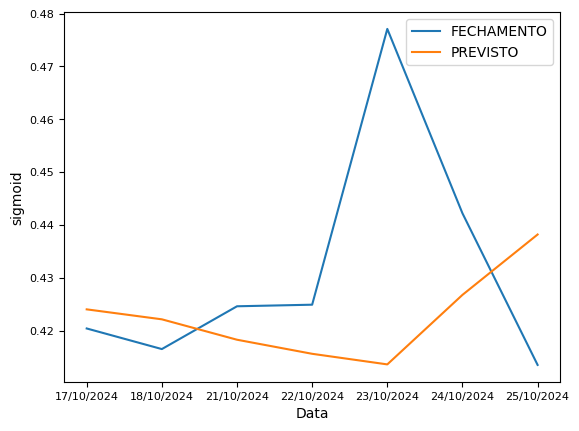

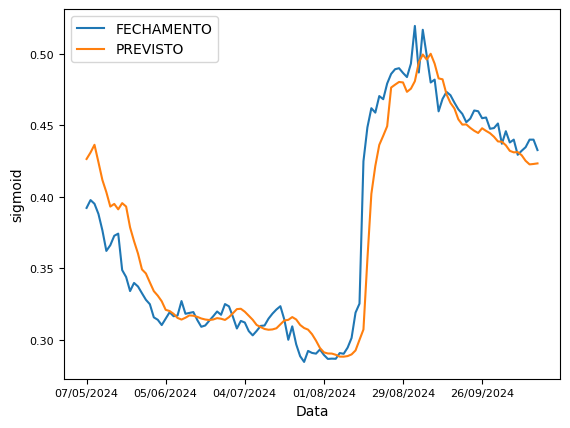

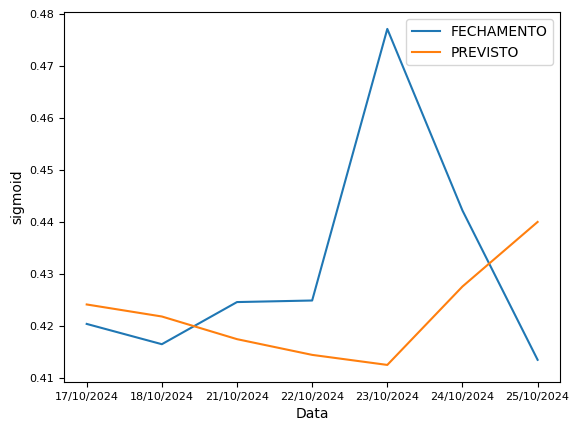

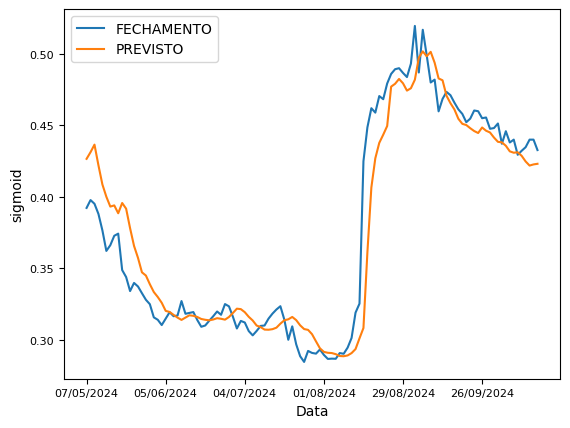

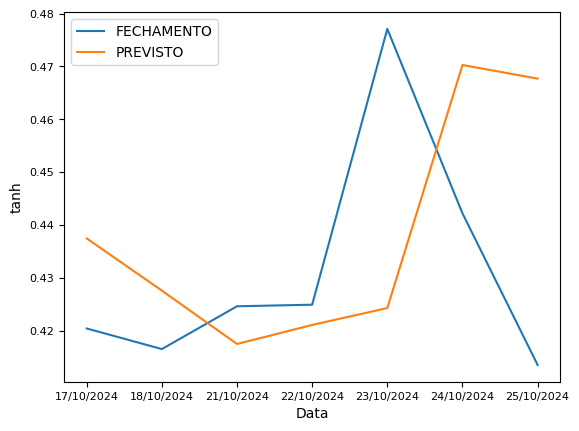

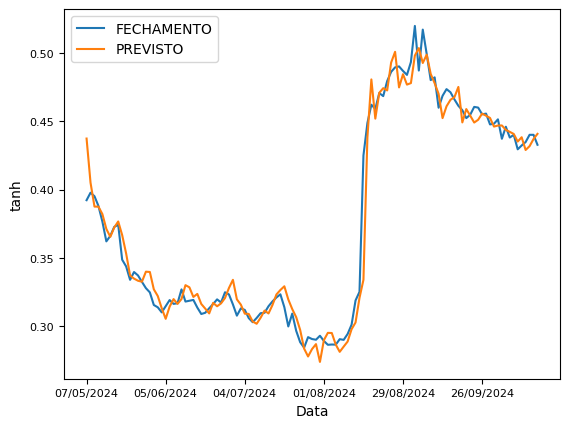

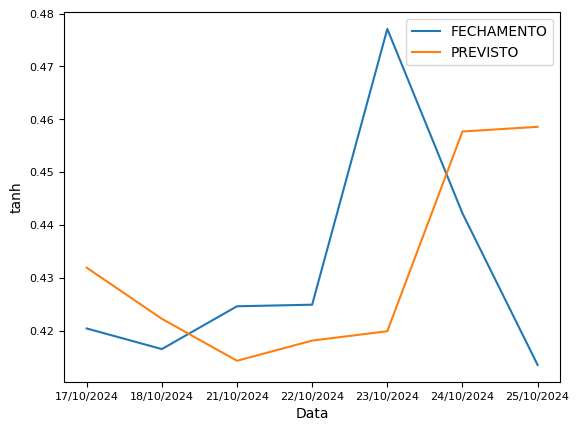

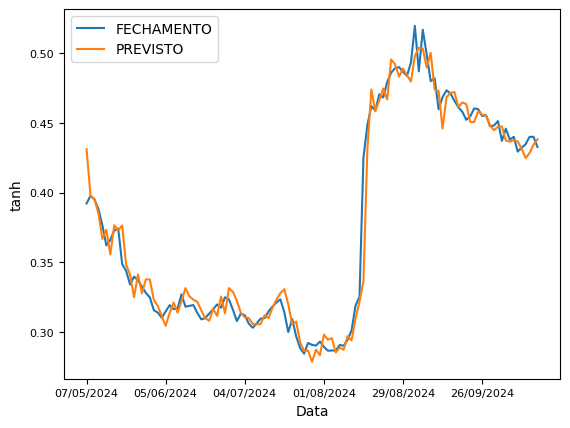

In [ ]:
from mlp_model import MLP
from concurrent.futures import ThreadPoolExecutor

models = [
    MLP(layers_sizes=[49, 100, 100, 1], activation='sigmoid'),
    MLP(layers_sizes=[49, 120, 120, 1], activation='sigmoid'),
    MLP(layers_sizes=[49, 100, 100, 1], activation='tanh'),
    MLP(layers_sizes=[49, 120, 120, 1], activation='tanh')
]

training_params = [
    {'learning_rate': 0.001, 'max_epochs': 10000, 'tolerated_error': 0.001},
    {'learning_rate': 0.001, 'max_epochs': 10000, 'tolerated_error': 0.001},
    {'learning_rate': 0.001, 'max_epochs': 10000, 'tolerated_error': 0.001},
    {'learning_rate': 0.001, 'max_epochs': 10000, 'tolerated_error': 0.001}
]

def execute(i : int):
    mlp = models[i]
    # error, epochs = mlp.train(x_train, t_train, learning_rate=0.001, max_epochs=10000, tolerated_error=0.0001)
    error, epochs = mlp.train(x_train, t_train, **training_params[i])

    y_test = mlp.predict(x_test)

    y = mlp.predict(x_train)

    return y, y_test, error, epochs, "sigmoid" if i < 2 else "tanh"

with ThreadPoolExecutor(max_workers=4) as executor:
    results = executor.map(execute, range(len(models)))

    for i, result in enumerate(results):
        y, y_test, error, epochs, legend = result
        print(f'Error: {error} - epochs: {epochs}')

        df_test = df.iloc[-N_TEST:].copy()
        df_test['PREVISTO'] = y_test

        df_test.plot(y=['FECHAMENTO', 'PREVISTO'], xlabel='Data', ylabel=legend, legend=legend, fontsize=8).get_figure().savefig(f'results/{STOCK_NAME}_{i}.png')

        df_predict = df.iloc[N_DAYS:-N_TEST].copy()
        df_predict['PREVISTO'] = y

        df_predict.plot(y=['FECHAMENTO', 'PREVISTO'], xlabel='Data', ylabel=legend, legend=legend, fontsize=8).get_figure().savefig(f'results/{STOCK_NAME}_test_{i}.png')
        